In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from os.path import join as pjoin
from scipy.stats.mstats import winsorize
from matplotlib import pyplot as plt


In [2]:
tmp_data_path = '../MA_data/data/tmp'


s_year = 1997

e_year = 2019

load data

In [3]:
df_ma = pd.read_pickle(pjoin(tmp_data_path , f'sdc_gvkey_{s_year}_{e_year}.pickle'))

In [4]:
df_fv_raw = pd.read_pickle(f'{tmp_data_path}/fv_raw_{s_year}_{e_year}.pickle')

recall that we have 2 types of public condition; 2 types of merge events

- 3,9: target = `AUP` acquirer `TUP` 
- 1,7: target = `AUP` acquirer `TPU`



|         | PubCond = 1,7 | PubCond = 3,9 |       |
|---------|---------------|------------------|-------|
| STATC=C | 5902          | 7991             | 13893 |
| STATC=W | 844           | 195              | 1039  |
|         | 6746          | 8186             |       |



SUMMARY:
- Our Goal is to modeling 2 types of MA events,
    - for each of which, anwsering: why some fail and why some success

In [5]:
df_fv_raw.head(10)

,gvkey,year,at,sale,ch,rdip,m2b,lev,roa,ppe,cash2asset,cash2sale,sale2asset,cr,gsi,de,roe,d_sale,d_at
0,10000,1997,577.137,559.823,16.809,NaN,1.187368,0.414770,-0.002807,0.218361,0.029125,0.030026,0.970000,1.832790,1.911871,1.302516,-0.008815,NaN,NaN
1,10000,1998,521.556,649.420,23.457,NaN,1.209249,0.306214,0.042674,0.209765,0.044975,0.036120,1.245159,2.086103,2.449992,0.778968,0.108557,0.160045,-0.096305
2,10000,1999,556.021,658.241,40.380,NaN,1.003037,0.351471,0.015620,0.191680,0.072623,0.061345,1.183842,2.218602,2.382590,0.960234,0.042674,0.013583,0.066081
3,10000,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10000,2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,10000,2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10000,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,10000,2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10000,2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
from dataloader_helpers import plot_missing

# The general missing pattern of financial vars

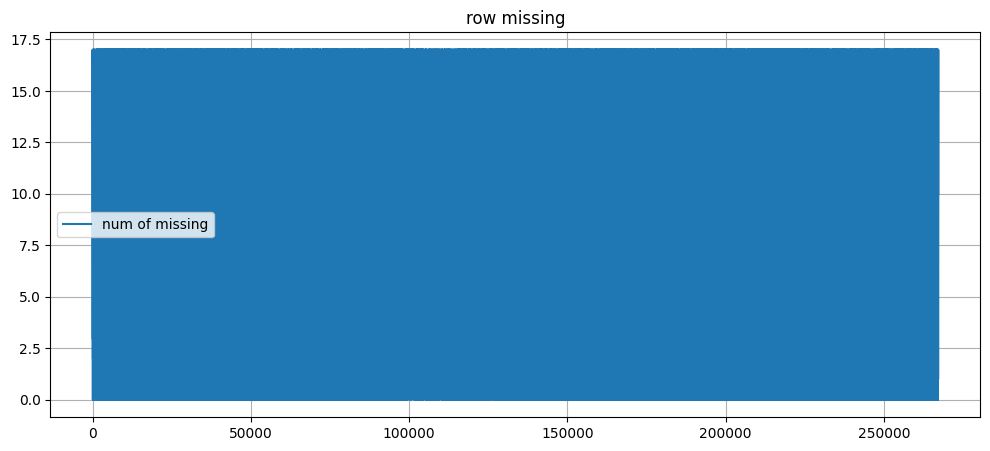

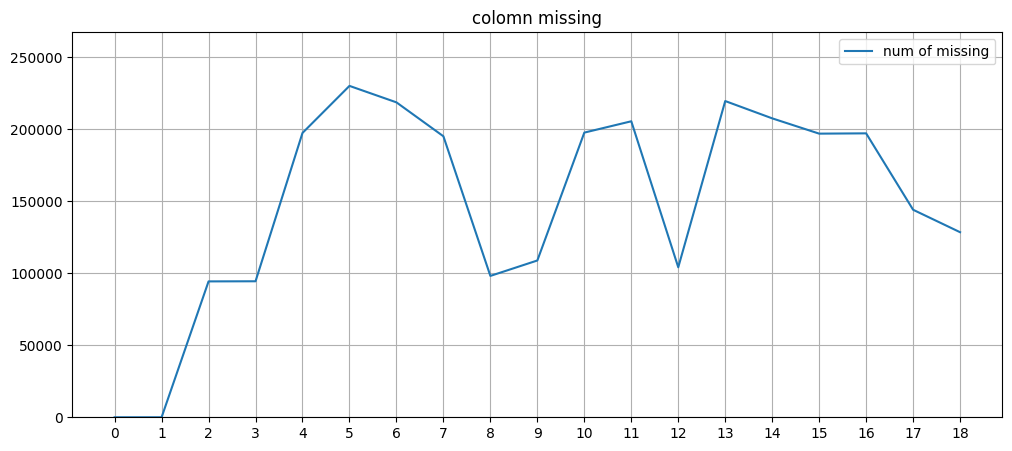

variable missing percentage : 
 gvkey          0.000000
year           0.000000
at            35.293523
sale          35.325713
ch            73.851659
rdip          86.074305
m2b           81.798344
lev           72.984789
roa           36.720341
ppe           40.724937
cash2asset    73.939993
cash2sale     76.884208
sale2asset    38.959381
cr            82.136334
gsi           77.642906
de            73.671622
roe           73.747605
d_sale        53.900916
d_at          48.069754
dtype: float64
variable names:  Index(['gvkey', 'year', 'at', 'sale', 'ch', 'rdip', 'm2b', 'lev', 'roa', 'ppe',
       'cash2asset', 'cash2sale', 'sale2asset', 'cr', 'gsi', 'de', 'roe',
       'd_sale', 'd_at'],
      dtype='object')


In [8]:
plot_missing(df_fv_raw)

# Dealing with NAs

First, one 1 condition we could analysis is that:
- both acquirer and the target has financial variable match
    - and their financial var has no missing values


    
Since we will never use some `gvkey-year` pair (hopefully they are the ones which have a lot of NAs), we first mark if the gvkey in `df_fv_raw` will be used further
- will use: 1
- will not: 0
    


In [9]:

merge_a = df_ma.merge(df_fv_raw, how = 'inner', left_on=['AGVKEY', 'YEAR'], right_on = ['gvkey','year'])
merge_t =  merge_a.merge(df_fv_raw, how = 'inner', left_on=['TGVKEY', 'YEAR'], right_on = ['gvkey','year'])



In [10]:
merge_t.shape

(24113, 79)

- after merge with financial variable, we loss about 1/3 of the MA events

- The result shows that we have a lot of NAs for financial data.


## Threshold 


by doing experiment, 7 is a reasonable number for threshold.

Which means the max tolerance of num of missing values per row is 7...

In [11]:
# def helper fun
def deal_na(df, na_thres):
    '''
    df: raw financial varibale table
        - the first 2 columns are `gvkey` and `year`
        - the rest are fianncial variables
    
    '''
    n_features = len(df.columns) - 2 # exclude gvkey and year
    print(f"totally {n_features} number of financial features, tolerance of num of missing is:", na_thres)
    ratio_pd_w = df
    # replace inf to na
    ratio_pd_w.replace([np.inf, -np.inf], np.nan, inplace=True)
    # count na of each row
    ratio_pd_w['n_na'] = ratio_pd_w.isna().sum(axis=1) # each row has how many Nas
     # only retain those Na < thres
    ratio_pd_w = ratio_pd_w[ratio_pd_w['n_na'] <= na_thres].reset_index(drop=True)
    
    for colname in ratio_pd_w.columns[2:(2+n_features)]:
        # remove outliers
        ratio_pd_w[colname] = winsorize(ratio_pd_w[colname], limits=[0.01, 0.01], nan_policy='omit')
        # impute na with mean
        ratio_pd_w[colname].fillna(value=ratio_pd_w[colname].mean(skipna=True), inplace=True)
    assert ratio_pd_w.isna().sum().sum() == 0
    return ratio_pd_w



def merge_fv_ma(df_fv_nona, df_ma):
    '''
    df_fv_nona: df_fv with no single missing value
    df_ma: 
    
    '''
    assert df_fv_nona.isna().sum().sum() == 0
    merge_a = df_ma.merge(df_fv_nona, how = 'inner', left_on=['AGVKEY', 'YEAR'], right_on = ['gvkey','year'])
    merge_t =  merge_a.merge(df_fv_nona, how = 'inner', left_on=['TGVKEY', 'YEAR'], right_on = ['gvkey','year'])

    #print("num of obs for original MA table: ", df_ma.shape[0], '\n')
    #print('num of obs in merged table:', merge_t.shape[0], '\n')
    
    return merge_t


In [12]:
# experiment:
remaining = []
for thres in range(0, df_fv_raw.shape[1]-2):
    #print(f" ########## when threshold is {thres}: ####### \n ")
    df_fv_nona = deal_na(df_fv_raw, thres)
    merged_fv_ma = merge_fv_ma(df_fv_nona, df_ma)
    remaining.append(merged_fv_ma.shape[0])
    

totally 17 number of financial features, tolerance of num of missing is: 0
totally 18 number of financial features, tolerance of num of missing is: 1
totally 18 number of financial features, tolerance of num of missing is: 2
totally 18 number of financial features, tolerance of num of missing is: 3
totally 18 number of financial features, tolerance of num of missing is: 4
totally 18 number of financial features, tolerance of num of missing is: 5
totally 18 number of financial features, tolerance of num of missing is: 6
totally 18 number of financial features, tolerance of num of missing is: 7
totally 18 number of financial features, tolerance of num of missing is: 8
totally 18 number of financial features, tolerance of num of missing is: 9
totally 18 number of financial features, tolerance of num of missing is: 10
totally 18 number of financial features, tolerance of num of missing is: 11
totally 18 number of financial features, tolerance of num of missing is: 12
totally 18 number of f

In [13]:
df_fv_raw.columns

Index(['gvkey', 'year', 'at', 'sale', 'ch', 'rdip', 'm2b', 'lev', 'roa', 'ppe',
       'cash2asset', 'cash2sale', 'sale2asset', 'cr', 'gsi', 'de', 'roe',
       'd_sale', 'd_at', 'n_na'],
      dtype='object')

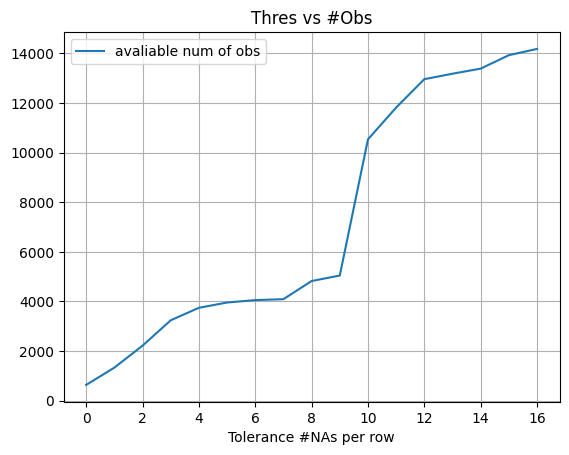

In [14]:



plt.plot(remaining, label = "avaliable num of obs") 
#plt.xlim([5, df_fv_raw.shape[1]-2])
plt.xlabel("Tolerance #NAs per row") 
plt.grid()
plt.title('Thres vs #Obs')
plt.legend()
plt.show()  
